<a href="https://colab.research.google.com/github/mpustil/DoctoradoPustilnik/blob/main/Modelos_SwiftV03_SMOTE_mas_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Modelo 03: Imputacion + SMOTE + RF  (19/10/2025)
# 26/10/2025 ahora hacemos SMOTE antes de agrupar

import pandas as pd
import numpy as np
import gc

'''
Archivos utilizados
Swift05_11SBS165.csv
https://drive.google.com/file/d/1T53fIqyrr70CHqXvB5lp0deJTxrfHUfV/view?usp=sharing
Swift05_11SBS52.csv
https://drive.google.com/file/d/1dQ5puACEkvwEE3zOl1vIrPglVQHXO7gD/view?usp=sharing

Swift11NoSBS.csv (solo registros sin flags de error)
https://drive.google.com/file/d/1-kSWbAy4ZL73eb6Wik3cei1s4iA1H1-j/view?usp=drive_link

'''
# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4']
  df[cols] = df[cols].applymap(np.int64)
  #variable target
  df['52'] = clase

  df.drop(['2', '112', '113', '114', '115'], axis=1, inplace=True)
  if clase == 1:
    df.drop(['50','51','53'], axis=1, inplace=True)

  # ponemos los NA
  listaVariables = ['110','111']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)

  #que tenga al menos uno de los filtros
  df = df[(df['110'] >= 0) | (df['111'] >=0 ) ]
  if clase == 0:
  #que no tenga flags
     df = df[(df['20'] == 0) & (df['21'] ==0 ) ]
     df.drop(['20','21'], axis=1, inplace=True)

  return df


dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')
dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)


#print(len(dfNoSBS),len(dfSBS),len(df))

#del dfSBS
#del dfNoSBS
#gc.collect()


/tmp/ipython-input-2257307794.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-2257307794.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)


In [ ]:
#imputacion lineal (en datos sin resumir)
from sklearn.linear_model import LinearRegression
import math

#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

#Imputacion por regresion lineal
def regresionLineal(df):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  #print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  #print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  #print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")

  #print()
  #print(df.corr())
  df['111'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)

#imputacion por regresion lineal (en toda la base)
regresionLineal(dfSBS)
regresionLineal(dfNoSBS)

frames = [dfSBS, dfNoSBS]
df = pd.concat(frames)



In [ ]:
# Pre-procesamiento parte 2: submuestreo y sobremuestreo  (ya viene todo imputado!)

# importamos librerias para balancear los datos
from imblearn.under_sampling import RandomUnderSampler

#SMOTE (Synthetic Minority Over-sampling Technique)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE


# vamos a dejar un 10% de SBS (sampling_strategy = 0.1) y 90% NoSBS, para luego, hacer oversamplig de SBS...
undersample = RandomUnderSampler(random_state=random_state, sampling_strategy = 0.1)

oversample = SMOTE(random_state=random_state)

# Separamos en X e y
X_SBS = df.drop(['52'], axis=1)
y_SBS = df['52']

#hacemos el submuestreo }
X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)


# ahora hacemos el oversampling de las SBS
X_over_SBS, y_over_SBS = oversample.fit_resample(X_over_SBS, y_over_SBS)

# preparamos todo para agrupar despues
df = X_over_SBS
df['52'] = y_over_SBS
dfSBS2 = df[(df['52'] == 1)]
dfNoSBS2 = df[(df['52'] == 0)]
dfSBS2.drop(['52'], axis=1,inplace= True)
dfNoSBS2.drop(['52'], axis=1,inplace= True)

print(len(dfSBS2), len(dfNoSBS2), len(X_over_SBS), len(df))


1890 1890 3780 3780


/tmp/ipython-input-3491654748.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSBS2.drop(['52'], axis=1,inplace= True)
/tmp/ipython-input-3491654748.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNoSBS2.drop(['52'], axis=1,inplace= True)


In [ ]:
# Agrupador prepM3b  (y submuestreo del modelo agrupado)

def desvio0(min, max, desvio)->float:
  ret = float('nan')
  if not math.isnan(min):
    ret = desvio
    if min == max:
      ret = 0.0
  return ret

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3b(df, clase):

  #2: obsid, 4: fuente   mantenemos la fuente, para poder hacer el ranking
#   df = df.groupby(['4'],group_keys=True).agg(
  df = df.groupby(['4'],group_keys=True).agg(
      #count=('2','count'),  # cant obs
      min110=('110', 'min'),
      max110=('110', 'max'),
      mean110=('110', 'mean'),
      std110=('110', 'std'),

      min111=('111', 'min'),
      max111=('111', 'max'),
      mean111=('111', 'mean'),
      std111=('111', 'std'))

  #corregimos el desvio muestral (cuando hay 1 sola muestra)
  df['std110'] = df.apply(lambda x: desvio0(x['min110'],x['max110'],x['std110']), axis=1)
  df['std111'] = df.apply(lambda x: desvio0(x['min111'],x['max111'],x['std111']), axis=1)

  #variable target
  df['52'] = clase

  return df

dfSBS2 = prepM3b(dfSBS2,1)
dfNoSBS2 = prepM3b(dfNoSBS2,0)

print(len(dfNoSBS2),len(dfSBS2))

# como quedan 1885 NoSBS y 605 SBS
# volvemos a sub muestrar el modelo agrupado  (con ratio 1 a 1)
undersample = RandomUnderSampler(random_state=random_state)

frames = [dfSBS2, dfNoSBS2]
df = pd.concat(frames)
# Separamos en X e y
X_SBS = df.drop(['52'], axis=1)
y_SBS = df['52']

# ahora quedan 605 de cada una
X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)

#finalmente tengo 605 de cada uno
print(len(X_over_SBS))


1885 605
1210


Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 20}
Mejor puntuación de validación cruzada:
0.8536134453781512
El accuracy en train es: 0.8819362455726092
El accuracy en test es: 0.8539944903581267
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       168
           1       0.97      0.75      0.85       195

    accuracy                           0.85       363
   macro avg       0.87      0.86      0.85       363
weighted avg       0.88      0.85      0.85       363



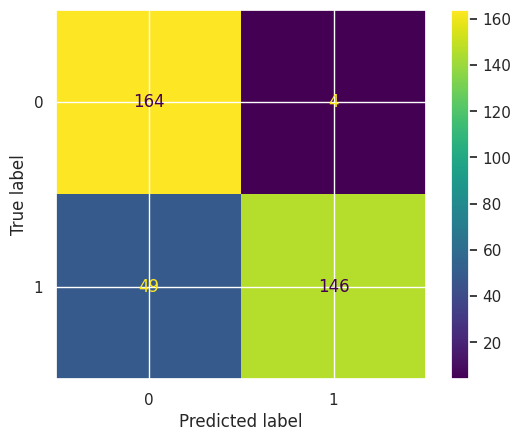

In [ ]:
#------------------------------------------------ Entrenamiento y metricas (para cualquier modelo RF)}
# 2/10/2025 se agregan mas hiperparametros en el gridsearch

from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

sns.set(context='notebook')

# 30% para test y 70% para train
X_train_SBS, X_test_SBS, y_train_SBS, y_test_SBS = train_test_split(X_over_SBS,y_over_SBS, test_size=0.30,random_state=random_state)

# Definir el clasificador y los valores de los hiperparámetros a probar

#clf = DecisionTreeClassifier(random_state=random_state, splitter='best')
clf = RandomForestClassifier(random_state=random_state)

# controlo el sobreajuste con 'min_samples_leaf' : [3]
#param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

#xxx se probo n_estimators 50,100,200 sin cambios significativos
#pero ver despues del nuevo subsampleo

param_grid = {'n_estimators':[10,20,30], 'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train_SBS, y_train_SBS)

# Imprimir los resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Modelo decision tree con parametros optimizados
best_clf = grid_search.best_estimator_

# Predecimos Y
y_train_pred_SBS = best_clf.predict(X_train_SBS)
y_test_pred_SBS = best_clf.predict(X_test_SBS)

# Graficamos matriz de confusion
cm = confusion_matrix(y_test_SBS,y_test_pred_SBS,labels=best_clf.classes_)
ConfusionMatrixDisplay(cm, display_labels=best_clf.classes_).plot()

# Calculo de las predicciones en Train y test
y_train_pred = best_clf.predict(X_train_SBS)
y_test_pred = best_clf.predict(X_test_SBS)

from sklearn.metrics import accuracy_score
print('El accuracy en train es:',accuracy_score(y_train_SBS,y_train_pred_SBS))
print('El accuracy en test es:', accuracy_score(y_test_SBS,y_test_pred_SBS))

print(classification_report(y_test_SBS,y_test_pred_SBS))

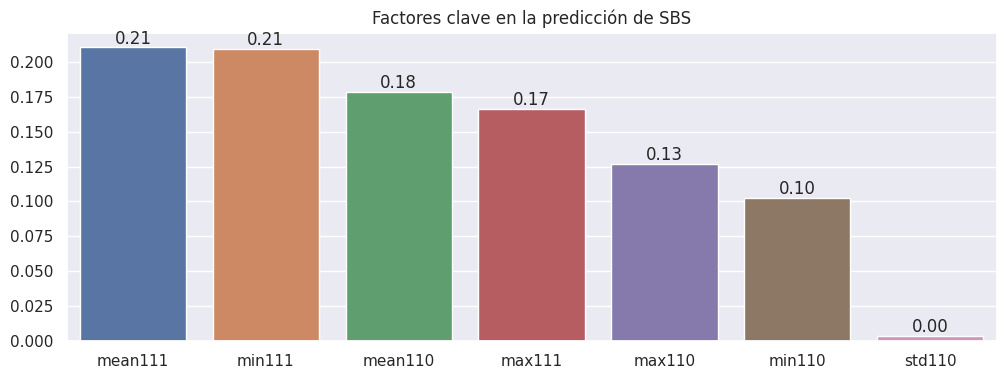

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=3,
                       n_estimators=20, random_state=41) instead.

<Figure size 1200x800 with 0 Axes>

In [ ]:
#importancia de atributos
#"112[2]:W1","113[3]:U","115[5]:V", "110[0]:W2","111[1]:M2""114[4]:B"

cantValMostrar = 7

feature_scores_SBS = pd.DataFrame(pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train_SBS.columns).sort_values(ascending=False).iloc[:cantValMostrar]).T

plt.figure(figsize=(12,4))
sns.barplot(data=feature_scores_SBS)

i = 0
for index, value in enumerate(feature_scores_SBS.values.flatten()):
    if i > cantValMostrar:
      break;
    i=i+1
    plt.annotate(f'{value:.2f}', xy=(index, value), ha='center', va='bottom')


plt.title("Factores clave en la predicción de SBS")
plt.show()

plt.figure(figsize = (12,8))

tree.plot_tree(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS));
tree.export_text(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS), feature_names=X_train_SBS.columns)



In [ ]:
'''
https://stackoverflow.com/questions/41682240/pandas-aggregate-count-in-dataframe

You can use 'size', 'count', or 'nunique' depending on your use case. The differences between them being:

'size': the count including NaN and repeat values.
'count': the count excluding NaN but including repeats.
'nunique': the count of unique values, excluding repeats and NaN.
'''

df = pd.read_csv(ruta + 'Swift05_11SBS165.csv', delimiter = ";")

df.groupby('4')['2'].agg(['size', 'count', 'nunique'])




In [ ]:
# histograma solo positivos
dfNoSBS['mm110'] = dfNoSBS['max110'] - dfNoSBS['min110']
dfNoSBS['mm111'] = dfNoSBS['max111'] - dfNoSBS['min111']


dfNoSBS110 =  dfNoSBS[(dfNoSBS['mm110'] >= 0.001)]
dfNoSBS111 =  dfNoSBS[(dfNoSBS['mm111'] >= 0.001)]

#importancia de atributos
#"112[2]:W1","113[3]:U","115[5]:V", "110[0]:W2","111[1]:M2""114[4]:B"
plt.figure(figsize=(10, 6))
sns.histplot(data=dfNoSBS111, x= 'mm110')
plt.title('Distrubución max-min M2 (NoSBS)')
plt.xlabel('NoSBS M2')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

NameError: name 'dfNoSBS' is not defined

In [ ]:
print(len(dfNoSBS110),len(dfNoSBS111))

397925 238163


In [ ]:

def correlaciones2(df, col1, col2):
  df2 = df[(df[col1] >= 0) & (df[col2] >=0 ) ]
  return len(df2), df2[col1].corr(df2[col2])

print(correlaciones2(dfSBS,'min110','min111'))
#print(correlaciones2(dfSBS,'min111','min112'))
#print(correlaciones2(dfSBS,'min112','min113'))
#print(correlaciones2(dfSBS,'min113','min114'))
#print(correlaciones2(dfSBS,'min114','min115'))
print(correlaciones2(dfNoSBS,'min110','min111'))
#print(correlaciones2(dfNoSBS,'min111','min112'))
#print(correlaciones2(dfNoSBS,'min112','min113'))
#print(correlaciones2(dfNoSBS,'min113','min114'))
#print(correlaciones2(dfNoSBS,'min114','min115'))


(15, np.float64(0.9919784636941983))
(518607, np.float64(0.9283876717976591))


In [ ]:
print(correlaciones2(dfSBS2,'min110','min111'))

(48, np.float64(0.41810305405598625))


In [ ]:
#"112[2]:W1","113[3]:U","115[5]:V", "110[0]:W2","111[1]:M2""114[4]:B"
def difMedia110(df, col):
  df['mm' + col] = df['max' + col] - df['min' + col]
  df2 =  df[~pd.isnull(df['mm' + col])]

  return round(df2['mm' + col ].sum() / len(df2),2) , len(df), round(100 - len(df2)*100/len(df),2)

#print(difMedia110(dfSBS,'110'),difMedia110(dfNoSBSMD,'110'),difMedia110(dfNoSBS,'110'))
#print(difMedia110(dfSBS,'111'),difMedia110(dfNoSBSMD,'111'),difMedia110(dfNoSBS,'111'))
#print(difMedia110(dfSBS,'112'),difMedia110(dfNoSBSMD,'112'),difMedia110(dfNoSBS,'112'))
#print(difMedia110(dfSBS,'113'),difMedia110(dfNoSBSMD,'113'),difMedia110(dfNoSBS,'113'))
print(difMedia110(dfSBS,'115'),difMedia110(dfNoSBSMD,'115'),difMedia110(dfNoSBS,'115'))

(np.float64(0.14), 52, 92.31) (np.float64(0.04), 520, 92.31) (np.float64(0.14), 6199964, 64.54)


In [ ]:
df['max110'].head()

,max110
4,
102635,NaN
119367,NaN
122972,NaN
124101,22.7121
127860,21.5422


In [ ]:
#ojo, que guarda sin fuentes!
dfSBS.to_csv("Swift05_11SBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)
dfNoSBS.to_csv("Swift05_11NoSBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)

In [ ]:
#muy desbalanceada la variable target (SBS)
#elegir alguna tecnica para esto...
df['52'].value_counts(normalize=True)

,proportion
52,
0,0.99995
1,0.00005


In [ ]:
y_SBS.head()

,52
4,
102635,1
119367,1
122972,1
124101,1
127860,1


El accuracy en train es: 0.675
              precision    recall  f1-score   support

           0       0.77      0.50      0.61       520
           1       0.63      0.85      0.72       520

    accuracy                           0.68      1040
   macro avg       0.70      0.68      0.67      1040
weighted avg       0.70      0.68      0.67      1040



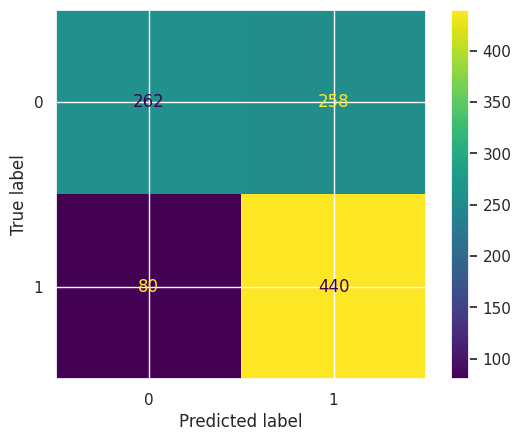

In [ ]:
#Dado el modelo02 entrenado, predecimos el 100% de la base

def metricas2(df):
  # se supone que son todas 0 (no sbs)
  # Separamos en X e y
  y_train = df['52']
  X_train = df.drop(['52'], axis=1)


  # Modelo decision tree con parametros optimizados
  #best_clf

  # Predecimos Y
  y_train_pred = best_clf.predict(X_train)

  # Graficamos matriz de confusion
  cm = confusion_matrix(y_train,y_train_pred,labels=best_clf.classes_)
  ConfusionMatrixDisplay(cm, display_labels=best_clf.classes_).plot()

  #from sklearn.metrics import accuracy_score
  print('El accuracy en train es:',accuracy_score(y_train,y_train_pred))

  print(classification_report(y_train,y_train_pred))

#copio 10 veces cada sd. dfNoSBSMD ya venia aumentado
frames = [dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfSBS,dfNoSBSMD]
dfTodosMD = pd.concat(frames)

#metricas2(dfSBS)
# NoSBS en general, el 100% de la base
#metricas2(dfNoSBS)

#Muestra que imita la distribucion de NA
#metricas2(dfTodosMD)

El accuracy en train es: 0.7678057485495077


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.77      0.87   6199964
           1       0.00      0.00      0.00         0

    accuracy                           0.77   6199964
   macro avg       0.50      0.38      0.43   6199964
weighted avg       1.00      0.77      0.87   6199964



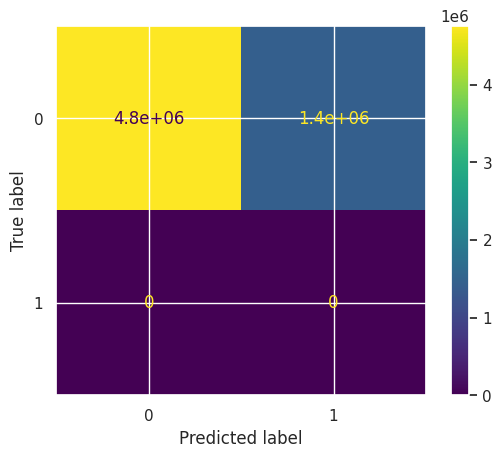

In [ ]:
#metricas2(dfSBS)
# NoSBS en general, el 100% de la base
metricas2(dfNoSBS)


In [ ]:
# recalculo la cantindad de mediciones para k filtros


uno = df["3"].where(df["3"] == 1).count()
dos = df["3"].where(df["3"] == 2).count()
tres = df["3"].where(df["3"] == 3).count()
cuatro = df["3"].where(df["3"] == 4).count()
cinco = df["3"].where(df["3"] == 5).count()
seis = df["3"].where(df["3"] == 6).count()
total = uno + dos + tres + cuatro + cinco + seis


print(uno, dos, tres, cuatro, cinco, seis , total)
print(uno*100 / total, dos*100 / total, tres*100 / total, cuatro*100 / total, cinco*100 / total, seis*100 / total )

4030459 933458 572926 298626 176888 187919 6200276
65.00450947667491 15.055103998596191 9.24033059173495 4.816333982551744 2.8529052577659444 3.0308166926762614


In [ ]:

import pandas as pd
import numpy as np
import gc
import math

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"


def SumaNoNaN(lista)->int:
  ret = 0
  for i in range(len(lista)):
    if not math.isnan(lista[i]):
      ret = ret + 1
  return ret

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM2(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4','52']
  df[cols] = df[cols].applymap(np.int64)


  listaVariables = ['min110','max110','mean110','std110',
                    'min111','max111','mean111','std111',
                    'min112','max112','mean112','std112',
                    'min113','max113','mean113','std113',
                    'min114','max114','mean114','std114',
                    'min115','max115','mean115','std115']

  # ponemos los NA
  listaVariables = ['110','111','112','113','114','115']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)


  #2: obsid, 4: fuente
  df = df.groupby(['4'],group_keys=True).agg(
      min110=('110', 'min'),
      max110=('110', 'max'),
      mean110=('110', 'mean'),
      std110=('110', 'std'))

  #df["GroupId"] = df.groupby(['4']).grouper.group_info[0]


  return df

#dfSBS : concateno SBS165 con SBS52  dando un total de 217 mediciones
dfSBS = prepM2(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')


#df.drop(['4'], axis=1, inplace=True)
dfSBS.head()


/tmp/ipython-input-2832067522.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)


,min110,max110,mean110,std110
4,,,,
102635,NaN,NaN,NaN,NaN
119367,NaN,NaN,NaN,NaN
122972,NaN,NaN,NaN,NaN
124101,21.1138,22.7121,21.537489,0.486109
127860,21.5422,21.5422,21.542200,NaN


In [ ]:

dfSBS['mm110'] = dfSBS['max110'] - dfSBS['min110']

dfSBS2 = dfSBS[~pd.isnull(dfSBS['mm110'])]

dfSBS2['mm110'].sum() / len(dfSBS2)


In [ ]:
dfSBS2['mm110'].sum() / len(dfSBS2)


np.float64(0.2126923076923076)